# **Traitement des données IMDB et première création d'un algorithme 🍿📹**

Cette étape se divise en deux parties: 
- Premièrement, un traitement des données est opéré, avec analyse graphique des données brutes: outliers, phénomènes récurrents. Certaines observations mènent déjà à des choix sur les données TMDB qui visent à rendre plus pertinent le travail.

- Dans un second temps, un preprocessing des données en vue de créer un algorithme de recommandation est efféctué, puis une première méthode triviale des KMeans, puis K-Nearest-Neighbors permet un clustering des films et une première appproche de recommandation.

## **Introduction**

In [175]:
#######Importation de tous les packages nécessaires#######

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors


In [134]:
# État général du DataFrame
df_ratings_imdb=pd.read_parquet('/Users/gustavetremey/Desktop/projet_python_films/projet_python_films/Data processing/data_IMDB_TMDB_join.parquet')
df_ratings_imdb.describe()

,averageRating_IMDB,numVotes_IMDB,isAdult,release_year,runtimeMinutes,tmdb_id,popularity_TMDB,budget,revenue,vote_average_TMDB,vote_count_TMDB
count,265654.000000,2.656540e+05,265654.000000,265654.0,265654.000000,2.386000e+05,238600.000000,2.386000e+05,2.386000e+05,238600.000000,238600.000000
mean,6.137748,4.262008e+03,0.012806,1996.85011,94.819054,4.649139e+05,1.624841,1.154117e+06,2.913961e+06,4.277066,93.032313
std,1.338916,4.012163e+04,0.112437,26.015858,157.845798,3.782425e+05,2.684879,9.382142e+06,3.318591e+07,2.775274,740.998257
min,1.000000,5.000000e+00,0.000000,1894.0,1.000000,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,5.300000,2.500000e+01,0.000000,1980.0,81.000000,1.552075e+05,0.157900,0.000000e+00,0.000000e+00,1.500000,1.000000
50%,6.200000,8.800000e+01,0.000000,2007.0,91.000000,3.759135e+05,1.353000,0.000000e+00,0.000000e+00,5.077000,3.000000
75%,7.000000,4.350000e+02,0.000000,2017.0,104.000000,6.626568e+05,2.386225,0.000000e+00,0.000000e+00,6.300000,13.000000
max,10.000000,3.128869e+06,1.000000,2025.0,59460.000000,1.593344e+06,458.174400,5.839000e+08,2.923706e+09,10.000000,38336.000000


In [135]:
# Simplification des noms de colonnes
df_ratings_imdb.rename(columns={'averageRating_IMDB':'averageRating', 'numVotes_IMDB':'numVotes'}, inplace=True)
df_ratings_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265654 entries, 0 to 265653
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tconst                265654 non-null  object 
 1   averageRating         265654 non-null  float64
 2   numVotes              265654 non-null  int64  
 3   originalTitle         265654 non-null  object 
 4   isAdult               265654 non-null  int64  
 5   release_year          265654 non-null  Int64  
 6   runtimeMinutes        265654 non-null  float64
 7   genres                265654 non-null  object 
 8   director_name         265654 non-null  object 
 9   primaryProfession     265654 non-null  object 
 10  tmdb_id               238600 non-null  float64
 11  original_language     238600 non-null  object 
 12  popularity_TMDB       238600 non-null  float64
 13  overview              238600 non-null  object 
 14  budget                238600 non-null  float64
 15  

---

# **Première partie: analyse individuelle des variables**

### Nombre d'avis

In [165]:
df_ratings_imdb['numVotes'].describe()

count    2.656540e+05
mean     4.262008e+03
std      4.012163e+04
min      5.000000e+00
25%      2.500000e+01
50%      8.800000e+01
75%      4.350000e+02
max      3.128869e+06
Name: numVotes, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


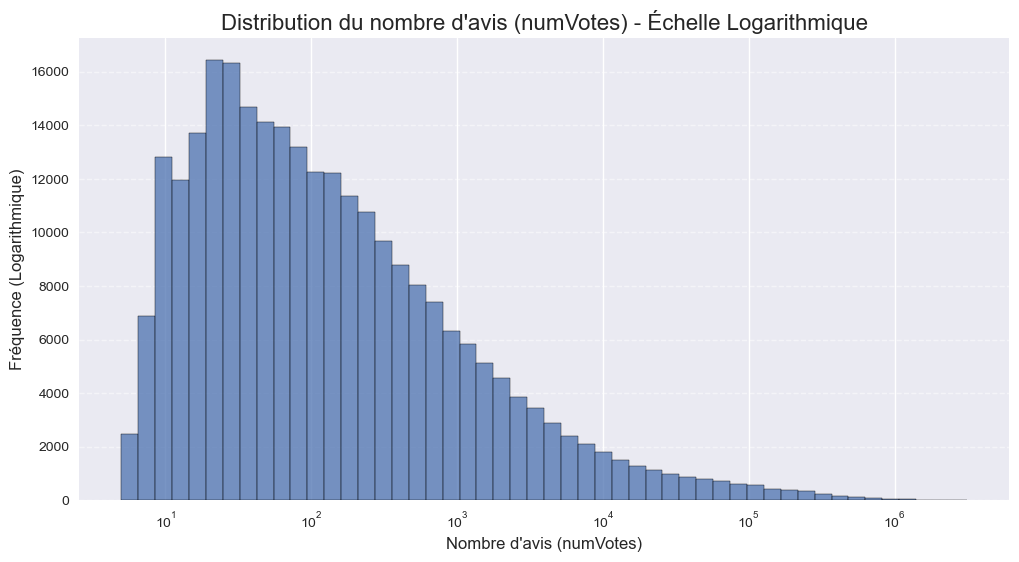

In [166]:
# Histogramme de la distribution du nombre de votes IMDB 
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb,
    x='numVotes',
    bins=50,
    log_scale=(True, False)  # échelle logarithmique appliquée à la fréquence des votes pour une meilleure visualisation
)

plt.title("Distribution du nombre d'avis (numVotes) - Échelle Logarithmique", fontsize=16)
plt.xlabel("Nombre d'avis (numVotes)", fontsize=12)
plt.ylabel("Fréquence (Logarithmique)", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*La distribution du nombre d'avis semble centrée vers 50, avec un décalage vers des films moins notés. On prend le parti de conserver tous ces films pour l'instant, afin de garder un groupe représentatif et divers. Le critère du nombre de votes n'est toutefois pas éliminé dans la sélection par la suite.*

*On teste sur les films à plus de 10 000 avis pour avoir une idée de la distribution sur des films de moyenne et plus grande ampleur*

In [158]:
# Création du filtre
mask = df_ratings_imdb['numVotes'] >= 10000
df_ratings_imdb_new=df_ratings_imdb.loc[mask]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


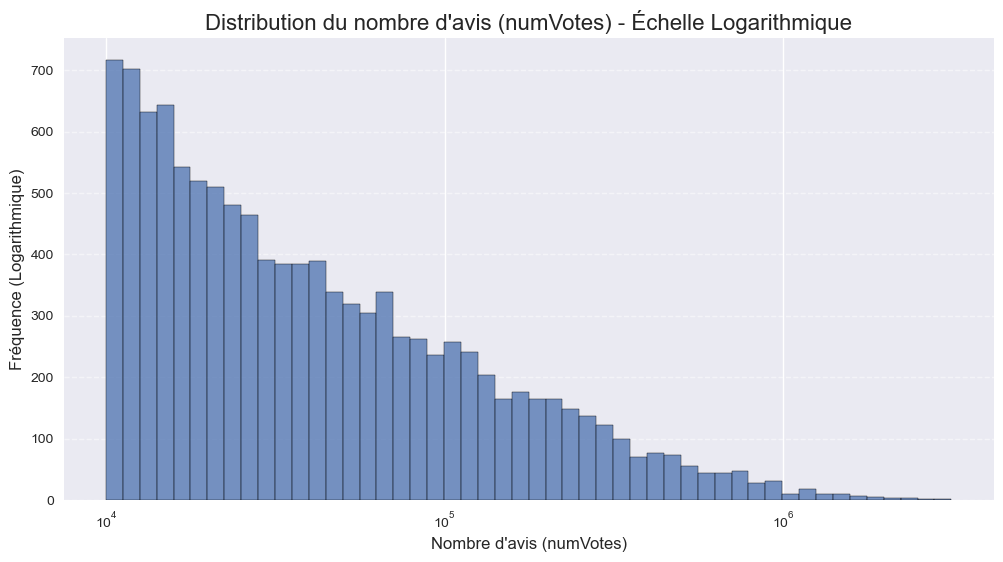

In [ ]:
# Histogramme de la distribution du nombre de votes IMDB, supérieurs à 10 000
plt.figure(figsize=(12, 6))

sns.histplot(
    data=df_ratings_imdb_new,
    x='numVotes',
    bins=50,
    log_scale=(True, False)  #  meilleure visualisation
)

plt.title("Distribution du nombre d'avis (numVotes) - Échelle Logarithmique", fontsize=16)
plt.xlabel("Nombre d'avis (numVotes)", fontsize=12)
plt.ylabel("Fréquence (Logarithmique)", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*Naturellement, il y a moins de films très connus que de films moins connus, la distribution est donc non centrée. On prend néanmoins le parti de la diversité en gardant des films relativement notés, dès 10 000 avis pour notre algorithme de recommandation. Celà évite un bruit trop fort avec des films moins connus et qui peuvent perturber l'analyse.*

####

### Ratings

On évalue désormais la distribution des notes des films, entre 0 et 10

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


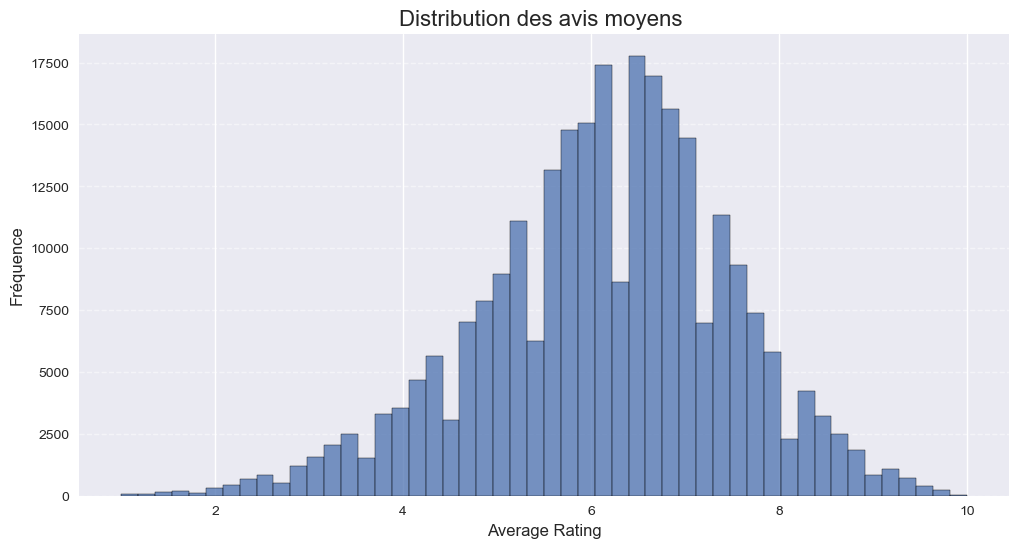

In [140]:
# Histogramme de la distribution du nombre d'avis moyens IMDB
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb,
    x='averageRating',
    bins=50  )

plt.title("Distribution des avis moyens ", fontsize=16)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*Moins d'aléa sur cette distribution qui semble normale, assez peu étonnant pour des avis de films.*

### Genres

Un premier formattage est nécessaire pour placer les genres de films sous forme de liste et les séparer quand ils sont plusieurs, afin de pouvoir les quantifier correctement dans les analyses. Par exemple, ne pas sortir un genre Romance, Aventure mais distinguer les deux.

In [ ]:
#Répartition des genres par la méthode explode
df_ratings_imdb_genres=df_ratings_imdb.copy()
df_ratings_imdb_genres['genres']=df_ratings_imdb_genres['genres'].astype(str) #on s'assure que la colonne est bien en str (chaine de caractères)
df_ratings_imdb_genres['genres']=df_ratings_imdb_genres['genres'].str.split(',') #on split les genres en une liste
df_ratings_imdb_genres=df_ratings_imdb_genres.explode('genres') #on divise la liste par genres
df_ratings_imdb_genres

,tconst,averageRating,numVotes,originalTitle,isAdult,release_year,runtimeMinutes,genres,director_name,primaryProfession,...,original_language,popularity_TMDB,overview,budget,country,production_companies,revenue,vote_average_TMDB,vote_count_TMDB,cast
0,tt0000009,5.2,231,Miss Jerry,0,1894,45.0,Romance,Alexander Black,"director,writer,cinematographer",...,en,0.2544,The adventures of a female reporter in the 1890s.,0.0,[US],['Alexander Black Photoplays'],0.0,4.5,4.0,"[{'name': 'Blanche Bayliss', 'gender': 0, 'pop..."
1,tt0000147,5.3,578,The Corbett-Fitzsimmons Fight,0,1897,100.0,Documentary,Enoch J. Rector,"director,cinematographer,editor",...,en,0.0511,"This legendary fight was filmed on March 17, 1...",0.0,[US],['Veriscope Company'],0.0,5.3,27.0,"[{'name': 'James J. Corbett', 'gender': 2, 'po..."
1,tt0000147,5.3,578,The Corbett-Fitzsimmons Fight,0,1897,100.0,News,Enoch J. Rector,"director,cinematographer,editor",...,en,0.0511,"This legendary fight was filmed on March 17, 1...",0.0,[US],['Veriscope Company'],0.0,5.3,27.0,"[{'name': 'James J. Corbett', 'gender': 2, 'po..."
1,tt0000147,5.3,578,The Corbett-Fitzsimmons Fight,0,1897,100.0,Sport,Enoch J. Rector,"director,cinematographer,editor",...,en,0.0511,"This legendary fight was filmed on March 17, 1...",0.0,[US],['Veriscope Company'],0.0,5.3,27.0,"[{'name': 'James J. Corbett', 'gender': 2, 'po..."
2,tt0000574,6.0,1039,The Story of the Kelly Gang,0,1906,70.0,Action,Charles Tait,"director,writer",...,en,0.1518,Just as Galeen and Wegener's Der Golem (1915) ...,0.0,[AU],"['Johnson and Gibson', 'J. & N. Tait']",0.0,5.2,40.0,"[{'name': 'Elizabeth Tait', 'gender': 0, 'pop'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265651,tt9916362,6.4,6167,Akelarre,0,2020,92.0,Drama,Pablo Agüero,"director,writer,producer",...,eu,2.4468,"French Basque Country, year 1609. The men of a...",0.0,[ES],"['INCAA', 'La Fidèle Production', 'Lamia Produ...",0.0,6.7,306.0,"[{'name': 'Àlex Brendemühl', 'gender': 2, 'pop..."
265651,tt9916362,6.4,6167,Akelarre,0,2020,92.0,History,Pablo Agüero,"director,writer,producer",...,eu,2.4468,"French Basque Country, year 1609. The men of a...",0.0,[ES],"['INCAA', 'La Fidèle Production', 'Lamia Produ...",0.0,6.7,306.0,"[{'name': 'Àlex Brendemühl', 'gender': 2, 'pop..."
265651,tt9916362,6.4,6167,Akelarre,0,2020,92.0,Horror,Pablo Agüero,"director,writer,producer",...,eu,2.4468,"French Basque Country, year 1609. The men of a...",0.0,[ES],"['INCAA', 'La Fidèle Production', 'Lamia Produ...",0.0,6.7,306.0,"[{'name': 'Àlex Brendemühl', 'gender': 2, 'pop..."
265652,tt9916538,7.6,12,Kuambil Lagi Hatiku,0,2019,123.0,Drama,Azhar Kinoi Lubis,"director,assistant_director,actor",...,id,2.1100,"Agra City, India, will be the witness to the m...",0.0,[ID],"['Perusahaan Film Negara', 'Taman Wisata Candi...",0.0,0.0,0.0,"[{'name': 'Lala Karmela', 'gender': 1, 'pop': ..."


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


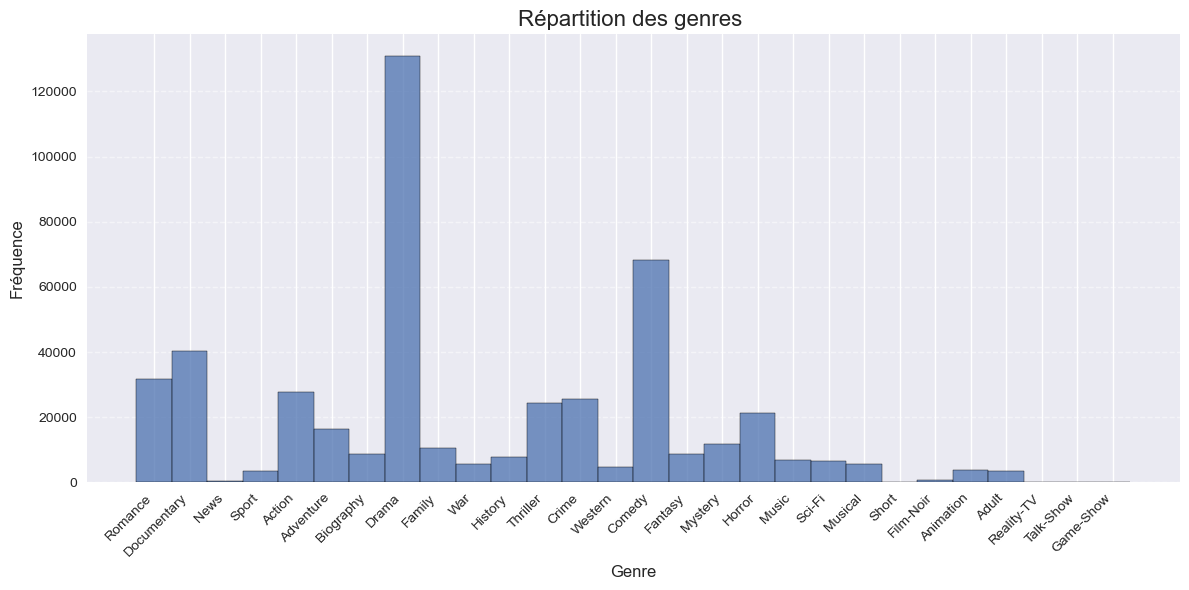

In [167]:
# Histogramme de la distribution des genres de films
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb_genres,
    x='genres',
    bins=50  
)

plt.title("Répartition des genres ", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45,ha='right') # rotation des labels de l'axe x pour une meilleure lisibilité
plt.tight_layout() # ajustement automatique des marges
plt.style.use('seaborn-v0_8')
plt.show()

*On observe une surreprésentation du genre drama et comedy, on les retire pour observer plus précisément la distribution des autres catégories*

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


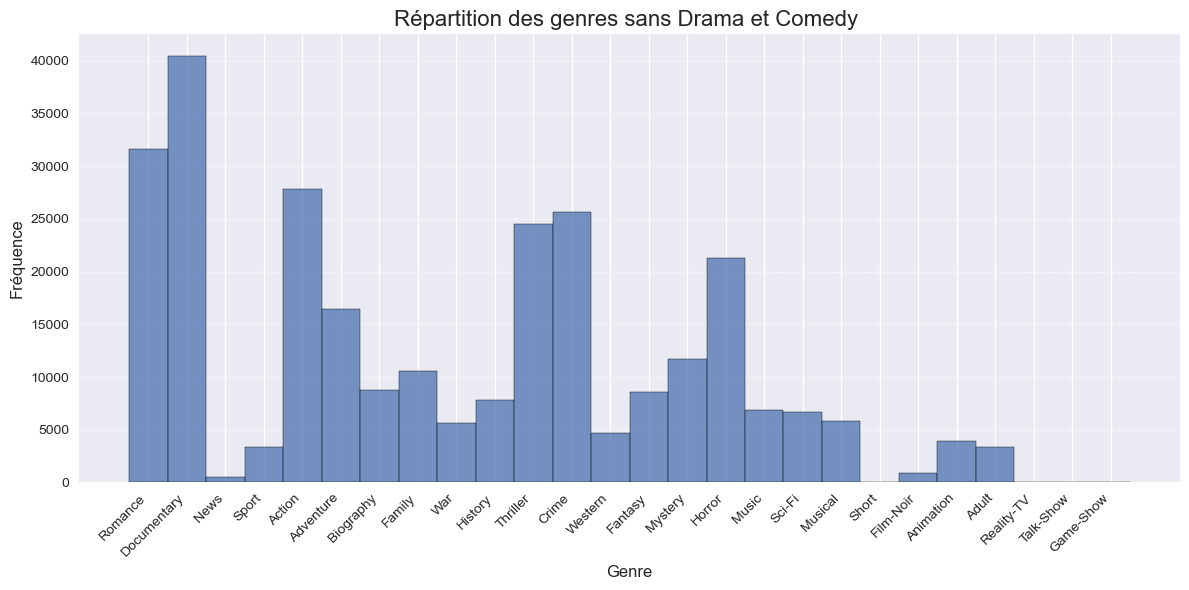

In [168]:
#Filtrage pour exclure les genres Comedy et Drama
mask_genres = (df_ratings_imdb_genres['genres'] != 'Comedy') &(df_ratings_imdb_genres['genres'] != 'Drama')

# Histogramme de la distribution du nombre de votes IMDB 
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb_genres[mask_genres],
    x='genres',
    bins=50  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Répartition des genres sans Drama et Comedy ", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.style.use('seaborn-v0_8')
plt.show()

*Certains genres prédominent clairement, on remarque surtout de faibles valeurs au niveau de news, talk show, game-show, short et film noir. Ces genres restent marginaux dans notre but de recommandation de films. Leur proportion empirique ne semble pas anormale non plus.
Par souci de précision et pour retirer du bruit à notre algorithme (focus sur des "vrais" films), on retire les genres suivants: Reality-TV, short, Talk-Show, Game-Show, News*

##### 

In [ ]:
#Tri du dataframe
genres_to_drop=(df_ratings_imdb['genres'] == 'Short') &(df_ratings_imdb['genres'] == 'Reality-TV')& (df_ratings_imdb['genres'] == 'Talk-Show')& (df_ratings_imdb['genres'] == 'Game-Show')&(df_ratings_imdb['genres'] == 'News')
df_ratings_imdb=df_ratings_imdb[~genres_to_drop]

### Réalisateurs

Brève analyse des réalisateurs. Dans cet algorithme, le focus sera plus fait sur la notation et le genre, ces statistiques restent donc descriptives.

In [ ]:
## Classement des réalisateurs avec plus de 20 films dans le dataset
df_ratings_imdb_directors = df_ratings_imdb.copy()
df_ratings_imdb_directors['director_name'] = df_ratings_imdb_directors['director_name'].astype(str)
df_ratings_imdb_directors['director_name'] = df_ratings_imdb_directors['director_name'].str.split(',')
df_ratings_imdb_directors = df_ratings_imdb_directors.explode('director_name')
df_ratings_imdb_directors

# Compter les films par réalisateur (index = nom du réalisateur)
director_counts = df_ratings_imdb_directors['director_name'].value_counts()

# sélection des réalisateurs ayant >= 20 films (Index de noms)
mask_20_films = director_counts >= 20
directors_20_films = director_counts[mask_20_films].index

# (optionnel) DataFrame contenant uniquement les lignes des réalisateurs avec >= 20 films
df_directors_20_films = df_ratings_imdb_directors[df_ratings_imdb_directors['director_name'].isin(directors_20_films)]
df_directors_20_films=df_directors_20_films.groupby('director_name').agg(moyenne_numVotes=('numVotes', 'mean'),
                                                  moyenne_Rating=('averageRating', 'mean'))

df_directors_20_films=pd.merge(df_directors_20_films,director_counts, on='director_name',how='left')

df_directors_20_films


,moyenne_numVotes,moyenne_Rating,count
director_name,,,
A. Bhimsingh,106.840000,7.036000,25
A. Edward Sutherland,610.767442,5.900000,43
A. Kodandarami Reddy,163.395349,6.862791,43
A. Razak Mohaideen,69.390244,5.102439,41
Aarne Tarkas,105.000000,5.574194,31
...,...,...,...
Çetin Inanç,256.066667,5.064444,45
Édouard Molinaro,1515.272727,6.160606,33
Éric Rohmer,6168.240000,7.144000,25


In [145]:
df_directors_20_films_famous=df_directors_20_films.copy()
df_directors_20_films_famous=df_directors_20_films_famous.loc[df_directors_20_films_famous['moyenne_numVotes']>10000]
df_directors_20_films_famous

,moyenne_numVotes,moyenne_Rating,count
director_name,,,
Akira Kurosawa,50570.214286,7.553571,28
Alfred Hitchcock,79434.566038,6.883019,53
Barry Levinson,63295.851852,6.385185,27
Billy Wilder,62358.600000,7.448000,25
Blake Edwards,16976.078947,6.289474,38
...,...,...,...
William Wyler,17330.804348,6.769565,46
Wilson Yip,22151.956522,6.152174,23
Wim Wenders,16209.387097,6.687097,31


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


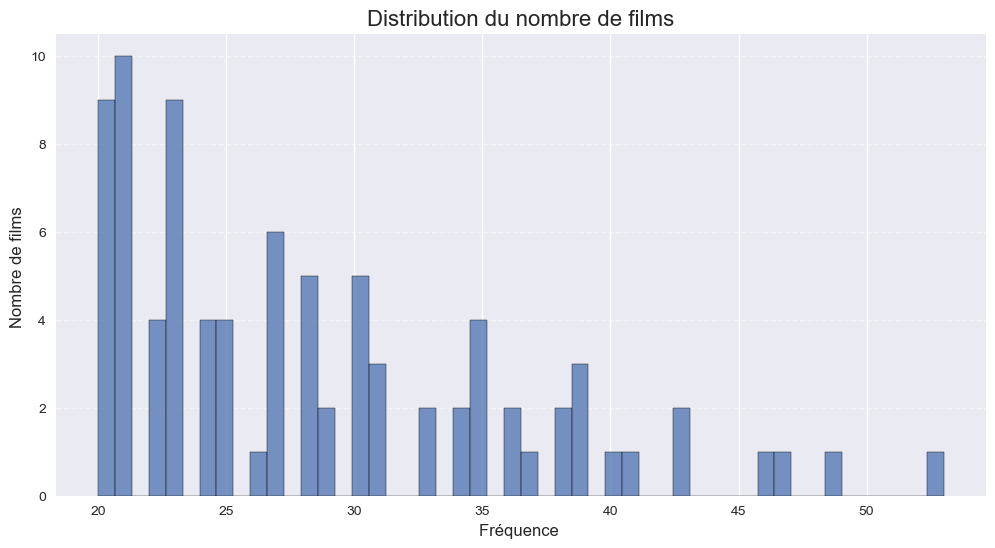

In [146]:
# Histogramme de la distribution des films par réalisateur (avec plus de 20 films et plus de 10 000 votes moyens)
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_directors_20_films_famous,
    x='count',
    bins=50,
      #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre de films", fontsize=16)
plt.ylabel("Nombre de films ", fontsize=12)
plt.xlabel("Fréquence ", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


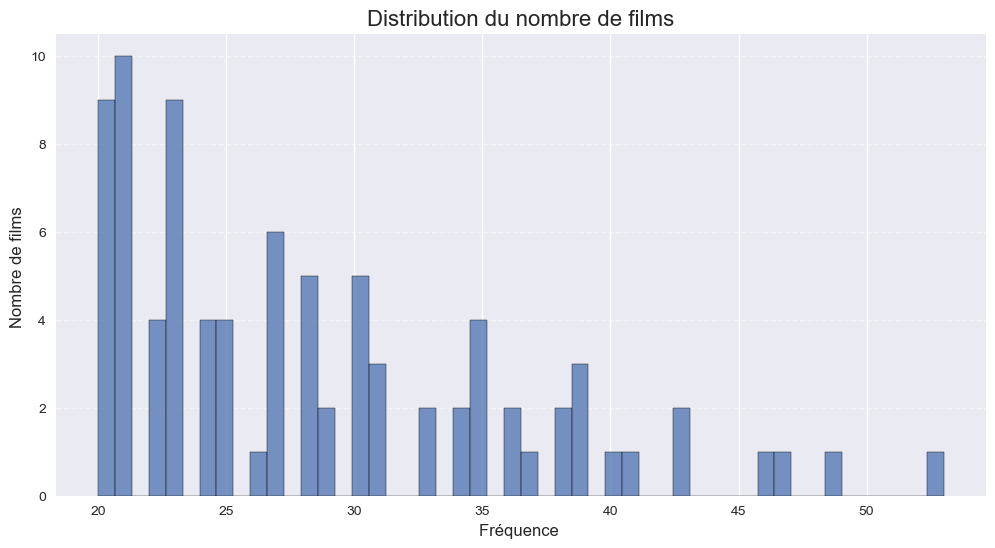

In [147]:
# Histogramme de la distribution des films par réalisateur (avec plus de 20 films et plus de 10 000 votes moyens)
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_directors_20_films_famous,
    x='count',
    bins=50,
      #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre de films", fontsize=16)
plt.ylabel("Nombre de films ", fontsize=12)
plt.xlabel("Fréquence ", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

### Année de sortie

In [148]:
df_ratings_imdb['release_year'].describe()

count      265654.0
mean     1996.85011
std       26.015858
min          1894.0
25%          1980.0
50%          2007.0
75%          2017.0
max          2025.0
Name: release_year, dtype: Float64

Pour des films débutant en 1894 dans le dataframe, on remarque une distribution bien plus concentrée sur les 20-30 dernières années observées. L'essor de la production cinématographique justifie particulièrement cette concentration récente.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


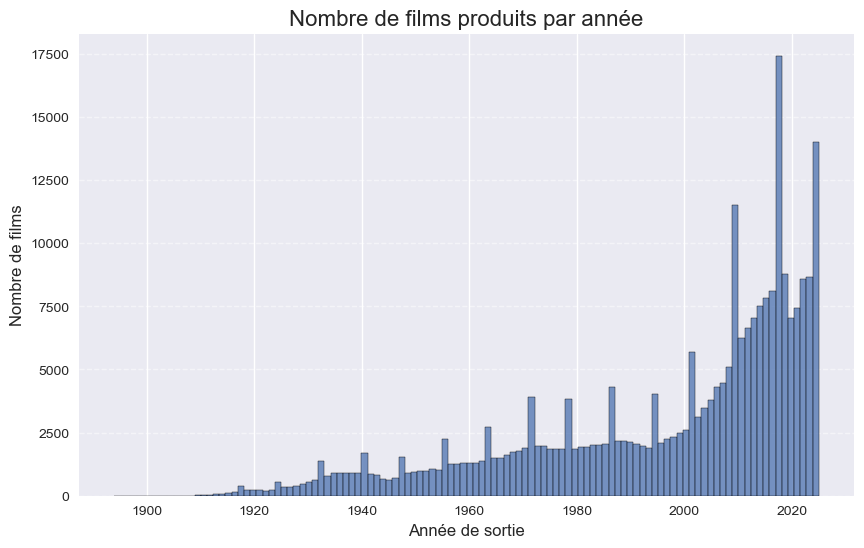

In [149]:
plt.figure(figsize=(10,6))


sns.histplot(
    data=df_ratings_imdb,
    x='release_year'
)

plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films", fontsize=12)
plt.title("Nombre de films produits par année", fontsize=16)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

On se concentre ici brièvement sur l'intervalle de temps 1990-2025 pour observer des valeurs particulières.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


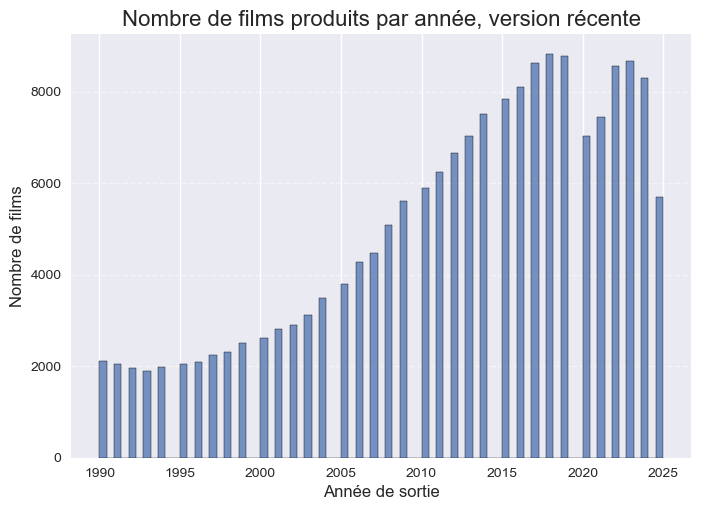

In [150]:
recent_movies=df_ratings_imdb['release_year']>=1990

df_recent_movies=df_ratings_imdb[recent_movies]

sns.histplot(
    data=df_recent_movies,
    x='release_year'
)

plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films", fontsize=12)
plt.title("Nombre de films produits par année, version récente", fontsize=16)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*Le choix est fait de ne pas discriminer de films par leur date de sortie ici, ce qui garde un algorithme pertinent et non excessivement biaisé par de nouveaux films.*

# **Deuxième partie: analyse globale des variables, mise en place d'un premier algorithme**

On produit maintenant une matrice de corrélation entre les facteurs du tableau afin de tester la pertinence des facteurs pour en prédire d'autres

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


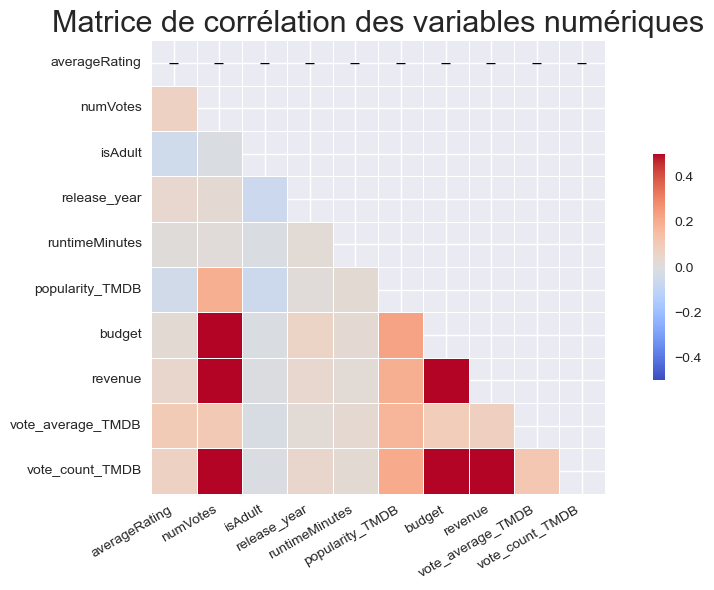

In [ ]:
column_labels=df_ratings_imdb.columns.tolist()
list_columns_object = [
    "tconst",
    "originalTitle",
    "genres",
    "director_name",
    "primaryProfession",
    "original_language",
    "overview",
    "country",
    "production_companies",
    "cast"
]
list_columns_object.append('tmdb_id') #classement des IDs par ordre chrnologique non pertinent pour les corrélations

corr=(df_ratings_imdb.drop(list_columns_object, axis=1).corr().dropna(how='all').dropna(axis=1, how='all'))

mask=np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True

fig=plt.figure(figsize=(10,6))



g = sns.heatmap(
    corr,
    mask=mask,     # on masque le traiangle supérieur
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmax=.5,
    vmin=-.5,
    center=0,      
    square=True,   
    linewidths=0.5, 
    cbar_kws={"shrink": .5},
    annot_kws={"size":12, "color":"black"} 
)



plt.title("Matrice de corrélation des variables numériques", fontsize=22)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Comme attendu, on observe clairement une forte corrélation entre des films très notés et un budget élevé: les blockbusters reçoivent plus de critiques. Il en va de même pour le revenu. La popularité est légèrement négativement corrélée à la notation moyenne, peut être à cause d'un aléa de notation moindre sur des films moins connus.

### Preprocessing global

On fait ici le choix de la standardisation plutôt que de la normalisation pour le traitement des données, au vu du nombre conséquent d'outliers et de valeurs significativement éloignées: de films à énormes budgets à des petites productions, les écarts sont significatifs et risquent d'être mal représentés par un processus de normalisation.

In [ ]:
#################################Standardisation des données numériques#################################

df_ratings_imdb['log_budget']=np.log1p(df_ratings_imdb['budget'])
df_ratings_imdb['log_revenue']=np.log1p(df_ratings_imdb['revenue'])
df_ratings_imdb['log_vote_count']=np.log1p(df_ratings_imdb['vote_count_TMDB'])



# Sélection des colonnes à transformer
cols_to_scale = ['averageRating','log_budget', 'log_revenue', 'popularity_TMDB', 'numVotes','log_vote_count']

# Il est important de traiter les valeurs manquantes avant le scaling
df_ratings_imdb[cols_to_scale] = df_ratings_imdb[cols_to_scale].fillna(0)


scaler_std=StandardScaler()

df_std=df_ratings_imdb.copy()
df_std[cols_to_scale]=scaler_std.fit_transform(df_std[cols_to_scale])
df_std.describe().loc[['mean','std']] #vérification de la standardisation: moenne proche de 0 et écart-type proche de 1

,averageRating,numVotes,isAdult,release_year,runtimeMinutes,tmdb_id,popularity_TMDB,budget,revenue,vote_average_TMDB,vote_count_TMDB,log_budget,log_revenue,log_vote_count
mean,-1.565497e-15,9.575399e-18,0.012806,1996.85011,94.819054,464913.925117,-7.296561e-17,1.154117e+06,2.913961e+06,4.277066,93.032313,-9.693085e-17,4.798398e-17,-1.830025e-16
std,1.000002e+00,1.000002e+00,0.112437,26.015858,157.845798,378242.461521,1.000002e+00,9.382142e+06,3.318591e+07,2.775274,740.998257,1.000002e+00,1.000002e+00,1.000002e+00


On encode les colonnes non numériques, comme les genres pour en faire des *dummies*, rendant l'analyse plus facile de manière numérique. Le parti de conserver les 10 catégories les plus fréquentes évite un bruit trop fort dans l'analyse; on étend juste pour les compagnies de production, pour éviter de se restreindre aux grosses productions. Celà aidera notamment à ne pas surcharger les K-Means et rendre le clustering imprécis.

In [ ]:
#################################Encodage des colonnes multi-label#################################

columns_to_process=['genres','original_language','primaryProfession','production_companies']

def encode_multilabel_column(df,column, top_n):
    """
    Nettoie, filtre le Top N et encode une colonne multi-label.
    """
    print(f"Traitement de la colonne : {column}...")
    
    # a. Transformation des chaînes "A, B" en listes réelles ["A", "B"]
    # On gère les NaN en les remplaçant par une liste vide
    temp_series = df[column].fillna('').str.split(',')
    
    # b. Identification du Top N des catégories les plus fréquentes
    # .explode() sépare chaque élément de la liste sur une ligne propre pour le comptage
    top_categories = temp_series.explode().value_counts().head(top_n).index.tolist()
    
    # c. Filtrage : on ne garde que les éléments appartenant au Top N
    filtered_series = temp_series.apply(
        lambda x: [item for item in x if item in top_categories]
    )
    
    # d. Application du MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    encoded_data = mlb.fit_transform(filtered_series)
    
    # e. Création du DataFrame avec préfixe pour éviter les collisions de noms (ex: 'genres_Action')
    encoded_df = pd.DataFrame(
        encoded_data, 
        columns=[f"{column}_{cls}" for cls in mlb.classes_],
        index=df.index
    )
    
    return encoded_df

df_final = df_std.copy()

top_n = 10  # Nombre de catégories à conserver pour chaque colonne
for col in columns_to_process:
    if col in df_final.columns:
        if col=='production_companies':
            top_n=30    #balayage plus large pour les compagnies de production
        # Générer les colonnes encodées
        df_encoded_part = encode_multilabel_column(df_final, col, top_n=top_n)
        
        # Joindre au DataFrame principal
        df_final = pd.concat([df_final, df_encoded_part], axis=1)
        


print("\nEncodage terminé !")
print(f"Nouvelles dimensions du DataFrame : {df_final.shape}")

Traitement de la colonne : genres...
Traitement de la colonne : original_language...
Traitement de la colonne : primaryProfession...
Traitement de la colonne : production_companies...

Encodage terminé !
Nouvelles dimensions du DataFrame : (265654, 84)


On procède maintenant au clustering des données. Après plusieurs essais, il apparaît que la production d'un film est relativement inutile dans la recommandation à un utilisateur, qui se reportera plutôt à la popularité d'un film et à sa note, ainsi qu'au genre de ce dernier. De même, la première profession du réalisateur ajoute beaucoup de variance au clustering et ne prédit pas mieux des clusters (diversité des parcours des réalisateurs non pertinente), on l'omet donc. On décide donc d'effectuer le clustering selon ces critères:
- genre
- origine du film
- popularité
- notation
- budget
- revenu

Prendre en compte le budget et le revenu compte moins, on se servira néanmoins de ces critères dans notre algorithme pour rapprocher des films qui appartiennent à la catégorie des *blockbusters*.

In [ ]:
# Préparation des données pour le clustering
features_clustering = [
    'averageRating', 'numVotes', 'popularity_TMDB', 'log_budget', 'log_revenue',
    'vote_average_TMDB', 'log_vote_count', 'genres_Action',
    'genres_Adventure', 'genres_Comedy', 'genres_Crime',
    'genres_Documentary', 'genres_Drama', 'genres_Horror', 'genres_Mystery',
    'genres_Romance', 'genres_Thriller', 'original_language_',
    'original_language_de', 'original_language_en', 'original_language_es',
    'original_language_fr', 'original_language_hi', 'original_language_it',
    'original_language_ja', 'original_language_ru', 'original_language_zh'
]

X=df_final[features_clustering]
X.fillna(0, inplace=True)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265654 entries, 0 to 265653
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   averageRating         265654 non-null  float64
 1   numVotes              265654 non-null  float64
 2   popularity_TMDB       265654 non-null  float64
 3   log_budget            265654 non-null  float64
 4   log_revenue           265654 non-null  float64
 5   vote_average_TMDB     265654 non-null  float64
 6   log_vote_count        265654 non-null  float64
 7   genres_Action         265654 non-null  int64  
 8   genres_Adventure      265654 non-null  int64  
 9   genres_Comedy         265654 non-null  int64  
 10  genres_Crime          265654 non-null  int64  
 11  genres_Documentary    265654 non-null  int64  
 12  genres_Drama          265654 non-null  int64  
 13  genres_Horror         265654 non-null  int64  
 14  genres_Mystery        265654 non-null  int64  
 15  

/var/folders/gk/2wm4vkt95dd9063d1r5_79pm0000gn/T/ipykernel_18321/2584385190.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
# Méthode du coude pour déterminer le nombre optimal de clusters: on regarde à quel moment l'inertie diminue substantiellemnt pour chosir le k optimal
inertias=[]
k_range=range(1,16)

for k in k_range:
    model=KMeans(n_clusters=k,random_state=42,n_init=10)
    model.fit(X)
    inertias.append(model.inertia_)

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(k_range,inertias,marker='o', linestyle='--')

ax.set_title("Méthode du coude pour déterminer le nombre optimal de clusters", fontsize=16)
ax.set_xlabel("Nombre de clusters (k)", fontsize=12)
ax.set_ylabel("Inertie", fontsize=12)
ax.grid(True,linestyle=':',alpha=0.6)
ax.legend()

plt.show()


Le coude se situe ici à 3, on choisit cette valeur pour K dans la suite.

In [ ]:
### Application du clustering K-Means avec le k optimal déterminé (k=3) ###
df_test=df_final.copy()

optimal_k=3

kmeans=KMeans(n_clusters=optimal_k,random_state=42,n_init=10)

clusters=kmeans.fit_predict(X)

df_test['cluster']=clusters

analysis=df_test.groupby('cluster')[['averageRating','numVotes','budget','revenue']].mean()
print(analysis)


         averageRating  numVotes        budget       revenue
cluster                                                     
0             0.130437 -0.104306  2.269282e+04  7.507290e+03
1            -0.099356 -0.080752  1.081760e+05  1.433978e+04
2             0.167146  1.470859  1.677072e+07  4.525129e+07


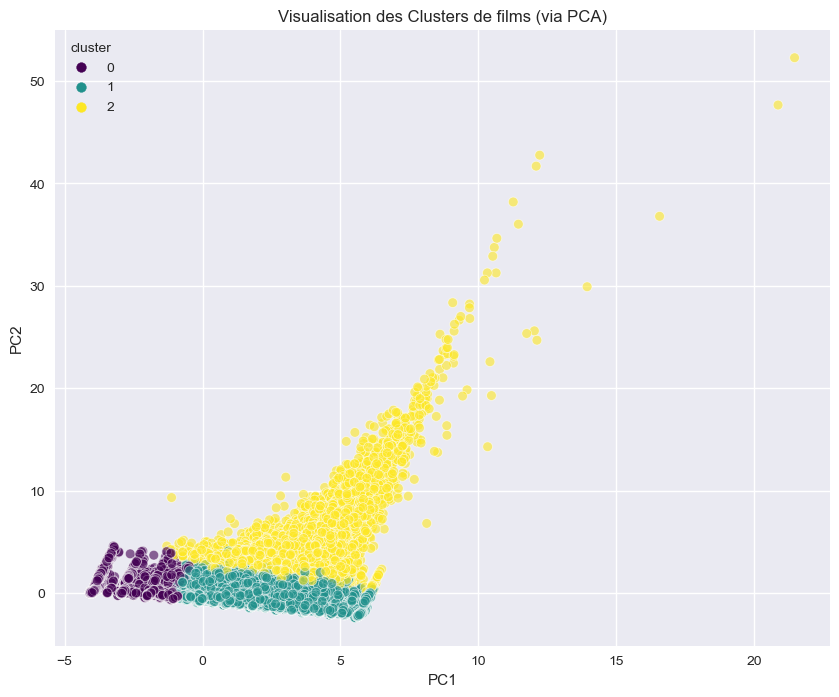

In [ ]:
# Visualisation des clusters avec PCA: réduction de la dimension à 2#

# Réduction de dimension à 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Création d'un petit DF temporaire pour le plot
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = clusters

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='viridis', alpha=0.6)
plt.title('Visualisation des Clusters de films (via PCA)')
plt.show()

On vérifie la cohérence des clusters via 3 méthodes: 
- silhouette score: test de la proximité des points d'un même cluster
- boxplots: test de la différence entre les clusters et de leur pertinence
- sanity check: test 'sensé' du sens des clusters; pas de combinaisons aberrantes

In [ ]:
# Calcul du score de silhouette pour chaque cluster et du socre général
score_moyen = silhouette_score(X, kmeans.labels_)
print(f"Score de silhouette global : {score_moyen:.3f}")

# Calcul pour chaque point pour voir la qualité par cluster
sample_silhouette_values = silhouette_samples(X, kmeans.labels_)
for i in range(3):
    cluster_score = sample_silhouette_values[kmeans.labels_ == i].mean()
    print(f"Score pour le cluster {i} : {cluster_score:.3f}")

Score de silhouette global : 0.478
Score pour le cluster 0 : 0.563
Score pour le cluster 1 : 0.452
Score pour le cluster 2 : 0.193


Ces scors obtenus sont bons, mais pas excellents. Ils sont néanmoins convenables pour de telles données, qui présentent de forts écarts entre elles. Le score particulièrement faible du cluster 2 rend compte de films plus distincts, à l'image des blockbusters.

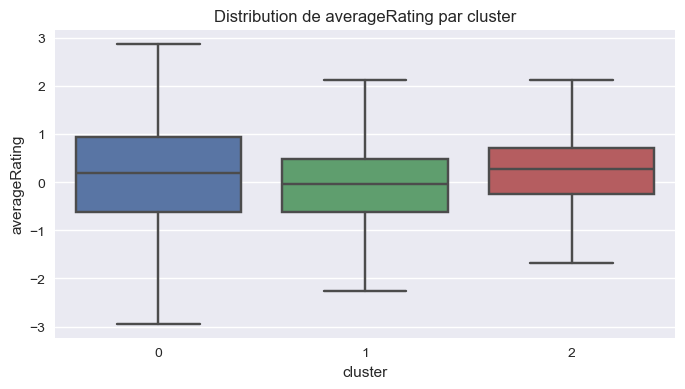

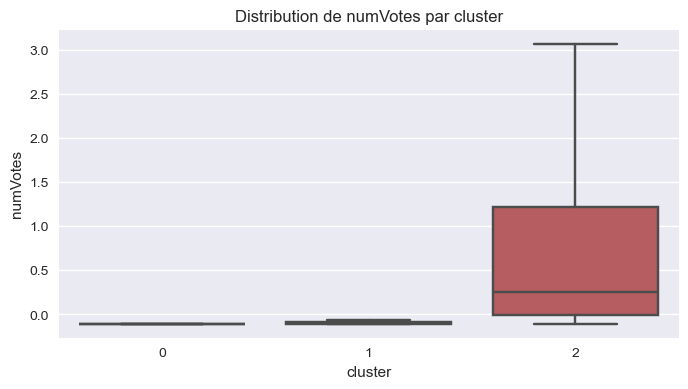

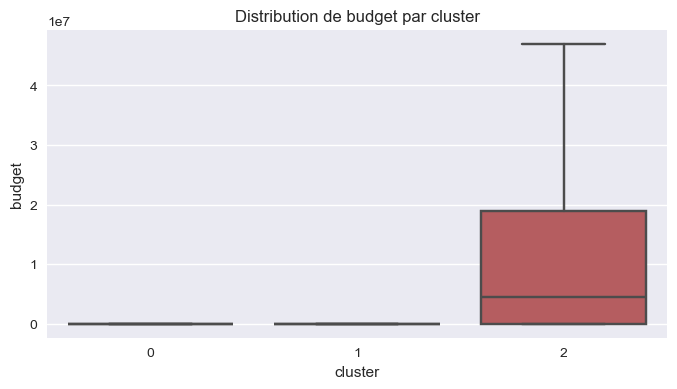

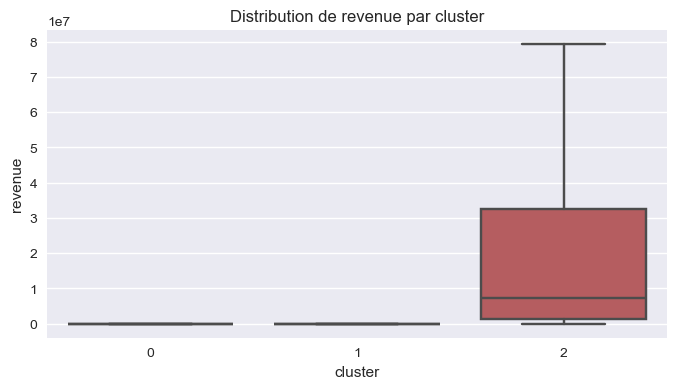

In [ ]:
# Boxplots des variables clés par cluster
vars_to_check=['averageRating','numVotes','budget','revenue']

for var in vars_to_check:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cluster',y=var,data=df_test,showfliers=False)
    plt.title(f"Distribution de {var} par cluster")
    plt.show()

On remarque bien que les clusters 0 et 1 rassemblent des films moins connus, plus ou moins bien notés tandis que le deuxième rassemble les films plus populaires.

In [ ]:
# Sanity check
for k in range(optimal_k):
               print(f"\n--Cluster {k}--")
               print(df_test[df_test['cluster']==k]['originalTitle'].sample(5).values)


--Cluster 0--
['Beyond the Lake' 'A Texas Steer' 'Mahamantri Timmarasu' 'Famous Pandey'
 'Insignificant Other']

--Cluster 1--
['Di Renjie tan an' 'I Am a Ghost' 'Tarzán y el tesoro Kawana'
 'Los muertos, la carne y el diablo' 'Koi']

--Cluster 2--
['Cop & ½' 'The War with Grandpa' 'Sobanggwan' 'Northfork'
 'Revenge of the Nerds II: Nerds in Paradise']


Le clustering est fait, désormais nous allons appliquer une méthode des K-Nearest Neighbors pour observer la proximité des films au sein des clusters entre eux. C'est cette classification qui permettra de rappprocher des films entre eux pour créer des recommandations à partir d'un point donné.

On applique manuellement plus de poids à certaines colonnes dans la recommandation: de manière assez évidente, un utilisateur valorise plus un film de même genre que de même budget; idem pour la notation. Le facteur peut encore être modifié pour tester l'algorithme selon différents paramètres.

In [191]:
# Méthode des Nearest Neighbors

knn=NearestNeighbors(n_neighbors=6, metric='euclidean') #le parti est pris de recommander 5 films pour un ici
knn.fit(X)

weight_rating=10
weight_genres=3

cols_genre=[c for c in X.columns if 'genre' in c]
X_weighted=X.copy()
X_weighted[cols_genre]=X_weighted[cols_genre]*weight_genres
X_weighted['averageRating']=X_weighted['averageRating']*weight_rating

knn_weighted=NearestNeighbors(n_neighbors=6, metric='euclidean') #le parti est pris de recommander 5 films pour un ici
knn_weighted.fit(X_weighted)


def recommend_movie(title,df,model_knn,X_data):
    try:
        idx=df[df['originalTitle'].str.lower()==title.lower()].index[0]
    except IndexError:
        return "Film introuvable"
    
    film_vector_df=X_data.iloc[idx:idx+1]
    distances,indices=model_knn.kneighbors(film_vector_df)

    print(f"Si vous avez aimé '{df.iloc[idx]['originalTitle']}', vous aimerez peut-être :")
    print("-" * 50)

    for i in range (1, len(indices[0])):
        film_idx=indices[0][i]
        dist=distances[0][i]
        film_title=df.iloc[film_idx]['originalTitle']
        film_genres=df.iloc[film_idx]['genres']
        film_rating=df.iloc[film_idx]['averageRating_original']
        print(f"{i}. {film_title} (Distance: {dist:.2f})| Genres: {film_genres} | Note IMDB: {film_rating}")



## Processus de "dé-normlaisation" de la colonne rating de IMDB pour une meilleure lisibilité dans les recommandations
# On repasse à la valeur non normalisée manuellement car on agit sur une seule colonne du fit et non pas les 6, afin d'éviter des erreurs de dimensionnalité
idx = 0 

# Formule : (Valeur_Scalée * Écart_Type) + Moyenne
mean = scaler_std.mean_[idx]
scale = scaler_std.scale_[idx]

df_test['averageRating_original'] = (df_test['averageRating'] * scale) + mean
df_test['averageRating_original'] = df_test['averageRating_original'].round(2)



## Algorithme final 

In [196]:
### Exemple d'application avec un film, le dataframe en question et le modèle KNN pondéré ###

recommend_movie("The Big Short",df_test,knn_weighted,X_weighted)

Si vous avez aimé 'The Big Short', vous aimerez peut-être :
--------------------------------------------------
1. Lost in Translation (Distance: 0.92)| Genres: Comedy,Drama | Note IMDB: 7.7
2. Jojo Rabbit (Distance: 1.74)| Genres: Comedy,Drama,War | Note IMDB: 7.9
3. The Breakfast Club (Distance: 1.80)| Genres: Comedy,Drama | Note IMDB: 7.8
4. About Time (Distance: 2.75)| Genres: Comedy,Drama,Fantasy | Note IMDB: 7.8
5. Juno (Distance: 3.27)| Genres: Comedy,Drama | Note IMDB: 7.4


*Attention: les noms de films sont en anglais dans le dataframe, le test implique donc de citer les noms de films anglais pour que l'algorithme fonctionne.*

Voici un exemple d'algorithme, encore modulable selon beaucoup de paramètres et perfectible, car dépendant du choix d'un seul film. Néanmoins, la minimisation de la distance opérée est efficace. Un autre algorithme, plus précis et détaillé dans une autre partie